# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## Data Loading and Overview

In [2]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

Using TensorFlow backend.


In [3]:
portfolio.head() # look into portfolio df

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [4]:
profile.head() # look into profile df

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head() # look into transcript df

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
portfolio.shape # get shape of portfolio

(10, 6)

In [7]:
portfolio.describe() # describe portfolio df

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [8]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [9]:
profile.describe() # desribe profile df

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [10]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [11]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [12]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


## Data Cleaning

In [13]:
channel_dummies = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0) # get dummy values for the column channels
portfolio = portfolio.drop(['channels'],axis=1) # drop the column channels
portfolio = pd.concat([portfolio,channel_dummies],axis = 1) # concat the portfolio df with dummies

In [14]:
portfolio = portfolio.rename(columns = {'id':'offer_id'}) # rename the column 'id' to 'offer_id'

In [15]:
portfolio.head()

,difficulty,duration,offer_id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [16]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d') # convert the column values in 'became_member_on' to datetime objects


In [17]:
profile = profile.rename(columns = {'id':'customer_id','became_member_on':'joining_date'}) # rename 'became_member_on' to 'joining_date'

In [18]:
profile.head()

,age,joining_date,gender,customer_id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [18]:
transcript.value.value_counts() # get value_counts of values column in transcript df

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}                  14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}                  14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}                  14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}                  14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}                  14374
{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}                  14305
{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}                  11848
{'offer id': '3f207df678b143eea3cee63160fa8bed'}                  11761
{'offer id': '2906b810c7d4411798c6938adc9daaa5'}                  11750
{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}                  10331
{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}      5317
{'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2', 'reward': 3}      5156
{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}      4354
{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d', 'reward': 5}   

In [19]:
values = transcript['value'].tolist() # get the list of values in value column of transcript df
transcript['offer_id'] = [val['offer id'] if 'offer id' in val.keys() else None  for val in values] # get only the offer_ids in 'value' column
                                                                                                    # and keep it in the column 'offer_id'
transcript['amount'] = [val['amount'] if 'amount' in val.keys() else None  for val in values] # get only the amount in 'value' column
                                                                                              # and keep it in the column 'amount'

In [20]:
event_dummies = pd.get_dummies(transcript.event) # get dummy values for the event column
transcript['interaction'] = transcript['event'].map({'offer completed':0,'offer received':1,
                                                    'offer viewed':2,'transaction':3}) # map the event column with the given dictionary and
                                                                                       # store it in the column 'interaction'
transcript = transcript.drop(['event'],axis=1)# drop the 'event' column
transcript = pd.concat([transcript,event_dummies],axis=1)# concat the transcript df with the dummies

In [21]:
transcript = transcript.rename(columns = {'person':'customer_id'}) # rename 'person' column to 'cuatomer_id'

In [22]:
transcript = transcript.drop(['value'],axis = 1) # drop the value column

In [23]:
transcript

,customer_id,time,offer_id,amount,interaction,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN,1,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,1,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,1,0,1,0,0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN,1,0,1,0,0
6,c4863c7985cf408faee930f111475da3,0,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,1,0,1,0,0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,NaN,1,0,1,0,0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,1,0,0
9,31dda685af34476cad5bc968bdb01c53,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,1,0,1,0,0


In [24]:
transcript.amount.isnull().sum()/transcript.shape[0] # get the percentage of null values in 'amount'

0.54669628817684168

In [25]:
df1 = pd.merge(transcript,profile,on = 'customer_id') # merge transcript df and profile df to get df1
df1

,customer_id,time,offer_id,amount,interaction,offer completed,offer received,offer viewed,transaction,age,joining_date,gender,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,1,0,0,75,2017-05-09,F,100000.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,2,0,0,1,0,75,2017-05-09,F,100000.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,3,0,0,0,1,75,2017-05-09,F,100000.0
3,78afa995795e4d85b5d9ceeca43f5fef,132,None,NaN,0,1,0,0,0,75,2017-05-09,F,100000.0
4,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,3,0,0,0,1,75,2017-05-09,F,100000.0
5,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,NaN,1,0,1,0,0,75,2017-05-09,F,100000.0
6,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,NaN,2,0,0,1,0,75,2017-05-09,F,100000.0
7,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67,3,0,0,0,1,75,2017-05-09,F,100000.0
8,78afa995795e4d85b5d9ceeca43f5fef,240,None,29.72,3,0,0,0,1,75,2017-05-09,F,100000.0
9,78afa995795e4d85b5d9ceeca43f5fef,378,None,23.93,3,0,0,0,1,75,2017-05-09,F,100000.0


In [26]:
df = pd.merge(df1,portfolio,on = 'offer_id',how = 'left') # merge df1 and portfolio df to get df

In [27]:
df

,customer_id,time,offer_id,amount,interaction,offer completed,offer received,offer viewed,transaction,age,...,gender,income,difficulty,duration,offer_type,reward,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,1,0,1,0,0,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,2,0,0,1,0,75,...,F,100000.0,5.0,7.0,bogo,5.0,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,132,None,19.89,3,0,0,0,1,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,132,None,NaN,0,1,0,0,0,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78afa995795e4d85b5d9ceeca43f5fef,144,None,17.78,3,0,0,0,1,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,78afa995795e4d85b5d9ceeca43f5fef,168,5a8bc65990b245e5a138643cd4eb9837,NaN,1,0,1,0,0,75,...,F,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
6,78afa995795e4d85b5d9ceeca43f5fef,216,5a8bc65990b245e5a138643cd4eb9837,NaN,2,0,0,1,0,75,...,F,100000.0,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0
7,78afa995795e4d85b5d9ceeca43f5fef,222,None,19.67,3,0,0,0,1,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,78afa995795e4d85b5d9ceeca43f5fef,240,None,29.72,3,0,0,0,1,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78afa995795e4d85b5d9ceeca43f5fef,378,None,23.93,3,0,0,0,1,75,...,F,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df['offer_type'].unique() # get the unique values in offer_type

array(['bogo', nan, 'informational', 'discount'], dtype=object)

It can be observed that the amount is nan whenever there the transaction column is 0. Since it can be perceived that when there is no transaction, amount is equal to 0, fill the null values in amount with 0.

In [30]:

for i in range(df.shape[0]):
    if df.iloc[i,8]==0: #if transaction = 0
        df.iloc[i,3]=0  # assign amount = 0

In [31]:
customers = df['customer_id'].unique() # get the unique values of 'customer_id'

In [32]:
customers_dict = pd.Series(customers).to_dict() # convert the unique customer_ids to a dictionary structure
customers_dict = {v:k for (k,v) in customers_dict.items()} # interchange the (key,value) pair with (value,key) pair
df['customer_id'] = df['customer_id'].map(customers_dict) # map the customer_id column to customers_dict

In [33]:
offers = df['offer_id'].unique() # get the unique_values of 'offer_id'

In [34]:
offers_dict = pd.Series(offers).to_dict()  # convert the unique offer_ids to a dictionary structure
offers_dict = {v:k for (k,v) in offers_dict.items()} # interchange the (key,value) pair with (value,key) pair
df['offer_id'] = df['offer_id'].map(offers_dict) # map the offer_id column to offers_dict

In [35]:
age_fn = lambda col:str(5*(col//5))+'-'+str(5*(col//5 + 1)) # divide the ages and bag them into groups of multiples of 5
df['age_group'] = df['age'].apply(age_fn) # apply the age_fn to 'age' in df

In [36]:
df1['age_group'] = df1['age'].apply(age_fn) # apply the age_fn to 'age' in df1

In [37]:
income_fn = lambda col:str(10000*(col//10000))+'-'+str(10000*(col//10000 + 1)) # divide the incomes and bag them into groups of multiples of 10000
df['income_group'] = df['income'].apply(income_fn) # apply the income_fn to 'age' in df

In [38]:
df['year'] = df['joining_date'].apply(lambda col:col.year) # get the year from joining_date column

In [39]:
df.head()

,customer_id,time,offer_id,amount,interaction,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward,email,mobile,social,web,age_group,income_group,year
0,0,0,0,0.00,1,0,1,0,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75-80,100000.0-110000.0,2017
1,0,6,0,0.00,2,0,0,1,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75-80,100000.0-110000.0,2017
2,0,132,1,19.89,3,0,0,0,1,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75-80,100000.0-110000.0,2017
3,0,132,1,0.00,0,1,0,0,0,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75-80,100000.0-110000.0,2017
4,0,144,1,17.78,3,0,0,0,1,75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75-80,100000.0-110000.0,2017


## Data visualisation

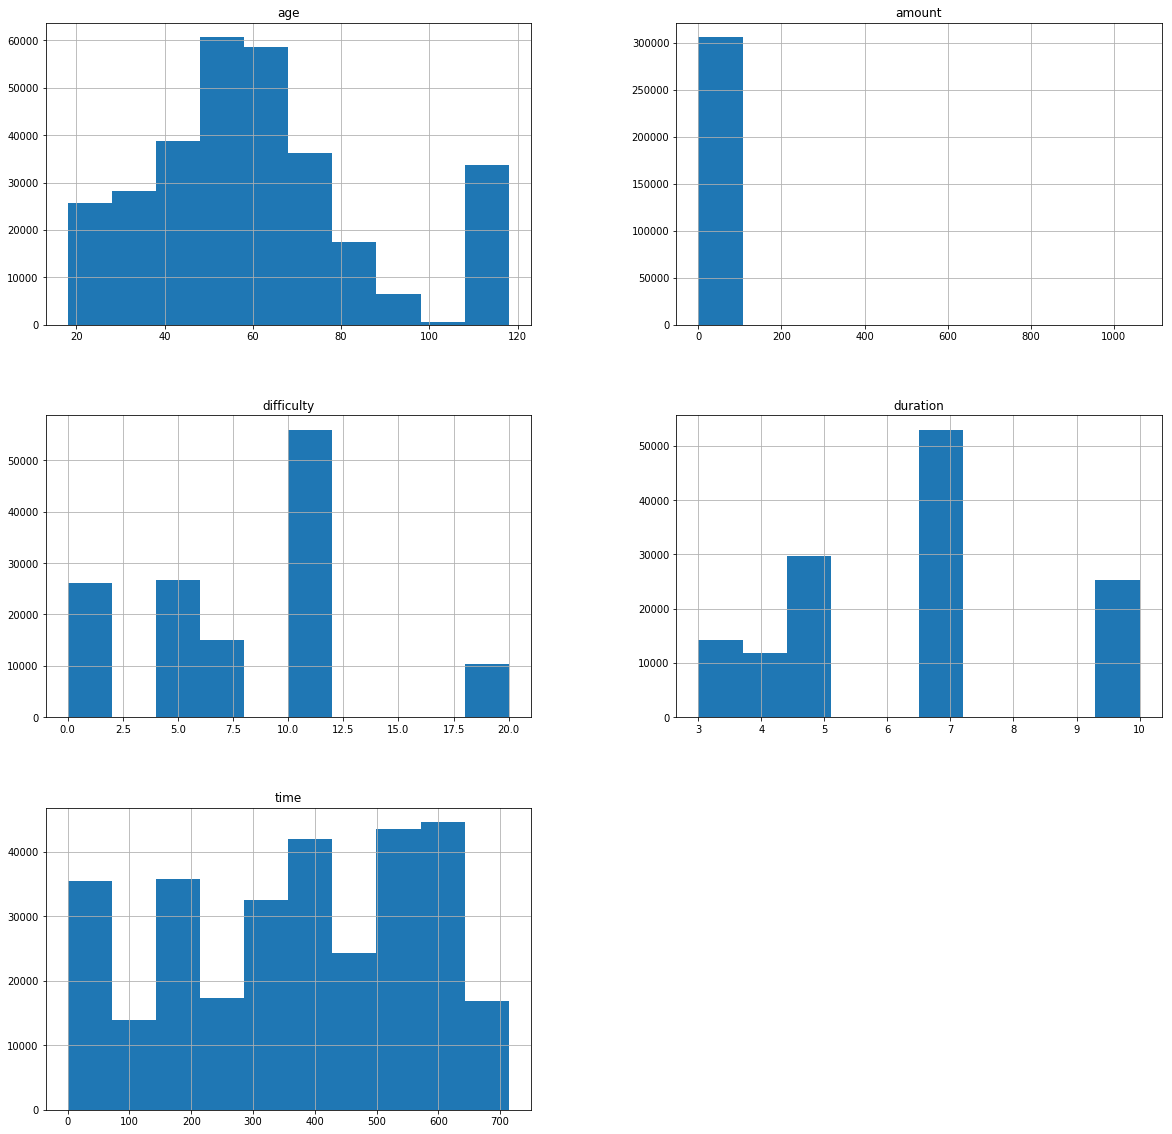

In [40]:
plt.figure(figsize = (15,15))
fig = df[['age','difficulty','duration','time','amount']].hist(figsize = (20,20))

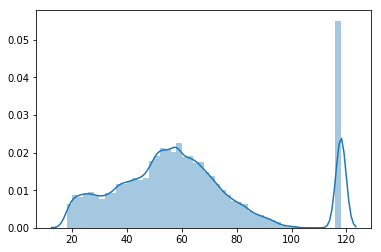

In [42]:
sns.distplot(df['age'].values)

In [44]:
df_bogo = df[df['offer_type']=='bogo'] # get the df corresponding to the offer_type of 'bogo' alone
df_disc = df[df['offer_type']=='discount'] # get the df corresponding to the offer_type of 'discount' alone
df_info = df[df['offer_type']=='informational'] # get the df corresponding to the offer_type of 'informational' alone

### Analyzing by age

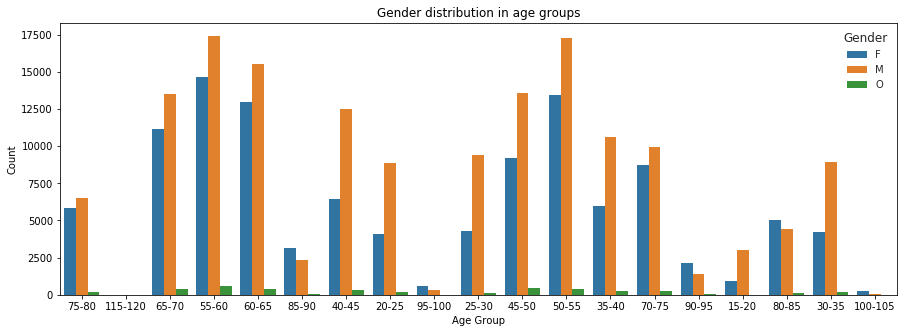

In [45]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", hue= "gender", data=df)
sns.set(style="darkgrid")
plt.title('Gender distribution in age groups')
plt.ylabel('Count')
plt.xlabel('Age Group')
plt.legend(title='Gender')

The highest number of users belong to the age group 55-60, and the number of males exceed that of females in every group except 90-95, 80-85, 95-100, 100-105

In [46]:
df_by_age = df.groupby(by='age_group').agg(sum) # group the df by age_group with sum as aggregate
df_by_age

,customer_id,time,offer_id,amount,interaction,offer completed,offer received,offer viewed,transaction,age,income,difficulty,duration,reward,email,mobile,social,web,year
age_group,,,,,,,,,,,,,,,,,,,
100-105,2811118,124368,986,2910.67,655,45.0,74.0,58.0,155.0,33298,2.448100e+07,1007.0,869.0,511.0,132.0,124.0,86.0,110.0,669501
115-120,277527240,12284904,113271,40509.57,70494,1135.0,9776.0,7865.0,14996.0,3985096,0.000000e+00,132338.0,113409.0,75500.0,17641.0,16251.0,11311.0,14062.0,68105501
15-20,30418308,1445796,11069,15337.69,8432,320.0,921.0,652.0,2069.0,73911,2.000730e+08,11077.0,9715.0,6845.0,1573.0,1485.0,1123.0,1195.0,7988961
20-25,105152798,4797792,36404,58134.69,27735,1146.0,3017.0,2069.0,6860.0,288171,6.542700e+08,38025.0,32455.0,22250.0,5086.0,4737.0,3525.0,3939.0,26399276
25-30,113823540,5103168,38667,58847.44,29435,1240.0,3157.0,2192.0,7298.0,374071,7.261730e+08,40414.0,34565.0,23756.0,5349.0,4979.0,3753.0,4143.0,28002479
30-35,109340231,4944942,36931,58623.48,28161,1237.0,3071.0,2111.0,6956.0,429524,6.767840e+08,38862.0,33483.0,22573.0,5182.0,4827.0,3501.0,4024.0,26970134
35-40,136518193,6136974,46852,95743.48,34740,1772.0,3822.0,2865.0,8396.0,626069,9.441800e+08,50061.0,43061.0,28665.0,6687.0,6155.0,4430.0,5179.0,33988047
40-45,158322595,7059792,55653,110646.89,38643,2117.0,4559.0,3629.0,8942.0,808035,1.143282e+09,60922.0,52484.0,35532.0,8188.0,7578.0,5387.0,6367.0,38809757
45-50,192974876,8516886,69179,136788.31,45533,2742.0,5729.0,4482.0,10280.0,1095873,1.452788e+09,77011.0,65791.0,44160.0,10211.0,9402.0,6627.0,8042.0,46848616


In [47]:
x_vals = df_by_age.index.to_series() #convert it to pandas series
y_vals = df_by_age['reward']

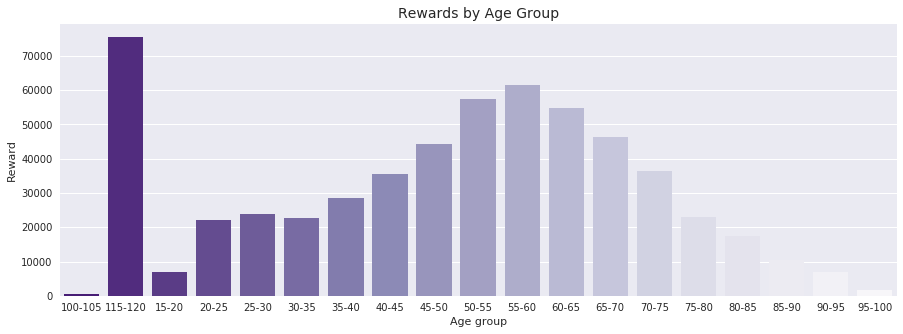

In [48]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Rewards by Age Group', fontsize = 14)
plt.ylabel('Reward')
plt.xlabel('Age group');

The highest amount of reward in completing the offer is acquired by the people in the age group 115-120

In [49]:
y_vals = df_by_age['income']

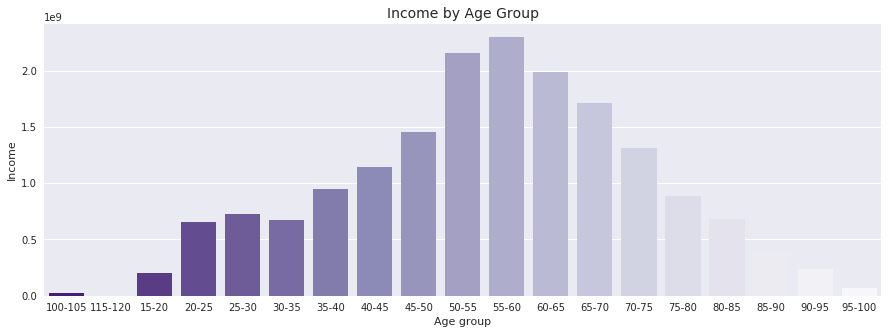

In [50]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Income by Age Group', fontsize = 14)
plt.ylabel('Income')
plt.xlabel('Age group');

People in the age group 55-60 seem to have the highest income among other users.

In [51]:
y_vals = df_by_age['amount']

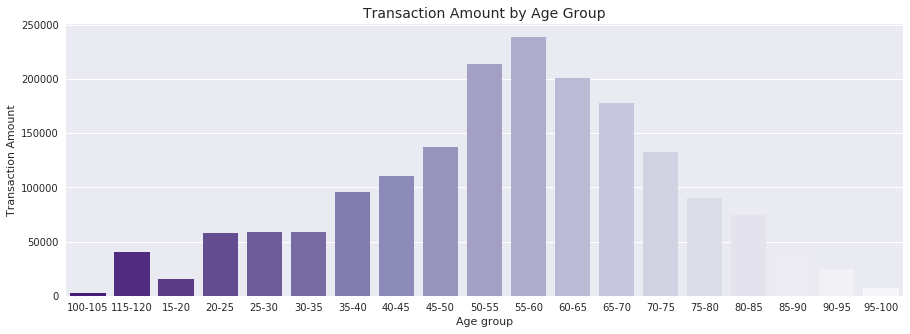

In [52]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Transaction Amount by Age Group', fontsize = 14)
plt.ylabel('Transaction Amount')
plt.xlabel('Age group');

The highest transaction with respect to the amount spent is done by the users in age group 55-60.

### Analyzing by gender

Text(0.5,0,'Gender')

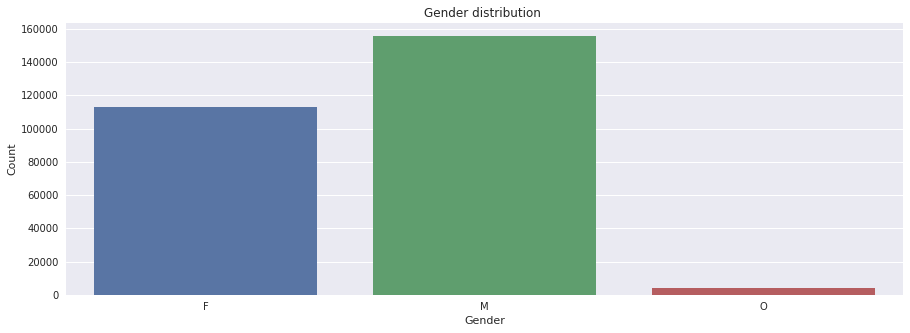

In [53]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "gender", data=df)
sns.set(style="darkgrid")
plt.title('Gender distribution ')
plt.ylabel('Count')
plt.xlabel('Gender')


In [54]:
df_by_gender = df.groupby(by='gender').agg(sum) # group the df by gender with sum as aggregate

In [55]:
x_vals = df_by_gender.index.to_series() #convert it to pandas series
y_vals = df_by_gender['reward']

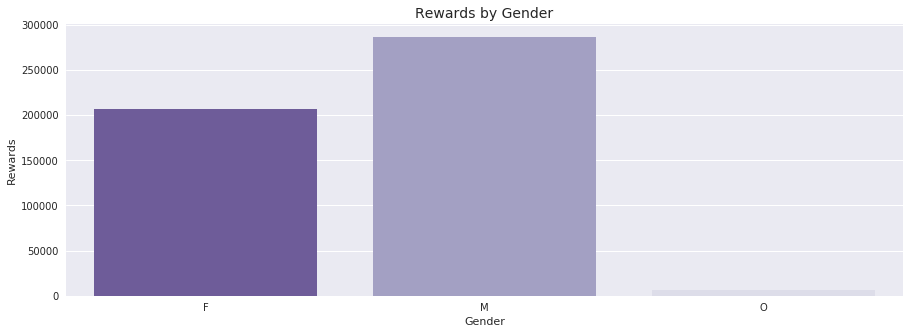

In [56]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Rewards by Gender', fontsize = 14)
plt.ylabel('Rewards')
plt.xlabel('Gender');

In [57]:
y_vals = df_by_gender['income']

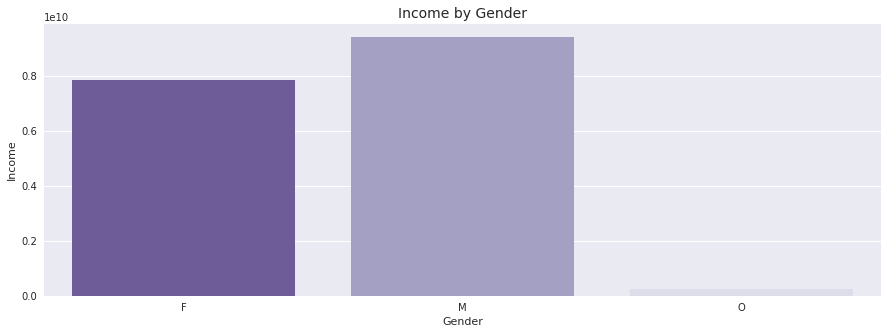

In [58]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Income by Gender', fontsize = 14)
plt.ylabel('Income')
plt.xlabel('Gender');

In [59]:
y_vals = df_by_gender['amount']

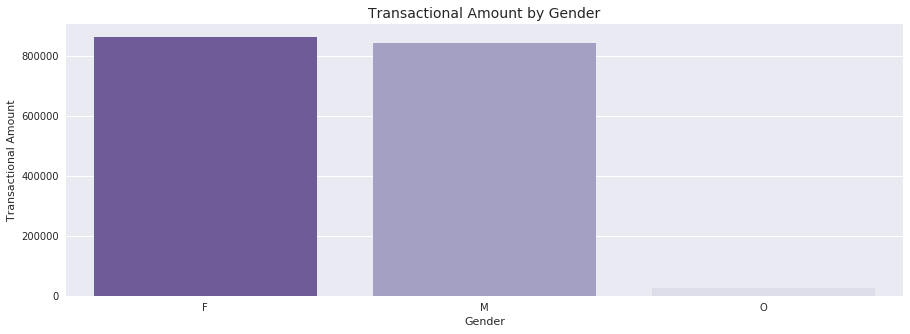

In [60]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Transactional Amount by Gender', fontsize = 14)
plt.ylabel('Transactional Amount')
plt.xlabel('Gender');

Number of males exceed that of females among the users. Except for the amount transacted, men lead when it comes to reward collected and income.

### Exploring demographic groups for the bogo offer

Text(0.5,0,'Age Group')

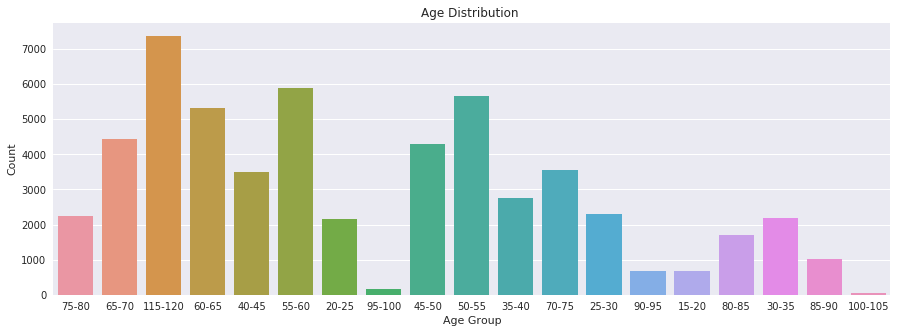

In [61]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", data=df_bogo)
sns.set(style="darkgrid")
plt.title('Age Distribution ')
plt.ylabel('Count')
plt.xlabel('Age Group')


Text(0.5,0,'Income Group')

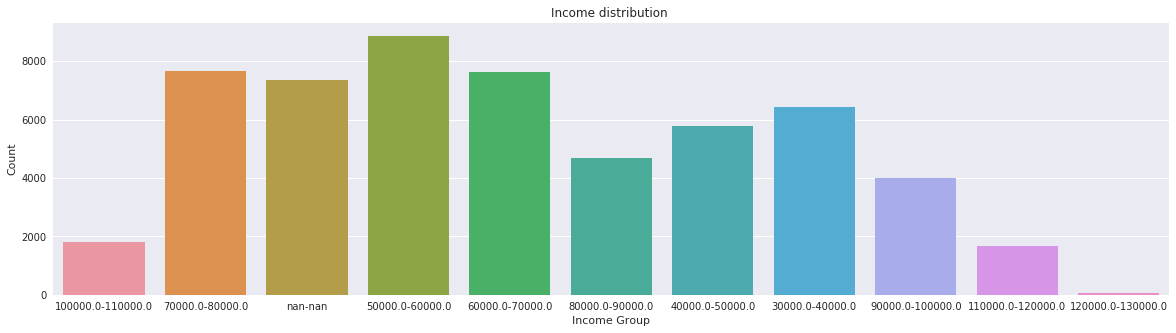

In [62]:
plt.figure(figsize=(20, 5))
sns.countplot(x= "income_group", data=df_bogo)
sns.set(style="darkgrid")
plt.title('Income distribution ')
plt.ylabel('Count')
plt.xlabel('Income Group')


In [63]:
print('Female Percentage: ',df_bogo[df_bogo['gender']=='F'].shape[0]/df_bogo.shape[0]) # get the percentage of female in the gender column
print('Male Percentage: ',df_bogo[df_bogo['gender']=='M'].shape[0]/df_bogo.shape[0])  # get the percentage of male in the gender column

Female Percentage:  0.3595838993350969
Male Percentage:  0.49669335811825266


In [64]:
df_bogo

,customer_id,time,offer_id,amount,interaction,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward,email,mobile,social,web,age_group,income_group,year
0,0,0,0,0.0,1,0,1,0,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75-80,100000.0-110000.0,2017
1,0,6,0,0.0,2,0,0,1,0,75,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,75-80,100000.0-110000.0,2017
10,0,408,3,0.0,1,0,1,0,0,75,...,7.0,bogo,10.0,1.0,1.0,1.0,0.0,75-80,100000.0-110000.0,2017
11,0,408,3,0.0,2,0,0,1,0,75,...,7.0,bogo,10.0,1.0,1.0,1.0,0.0,75-80,100000.0-110000.0,2017
12,0,504,4,0.0,1,0,1,0,0,75,...,5.0,bogo,5.0,1.0,1.0,1.0,1.0,75-80,100000.0-110000.0,2017
17,0,582,4,0.0,2,0,0,1,0,75,...,5.0,bogo,5.0,1.0,1.0,1.0,1.0,75-80,100000.0-110000.0,2017
34,2,408,0,0.0,1,0,1,0,0,68,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,65-70,70000.0-80000.0,2018
35,2,420,0,0.0,2,0,0,1,0,68,...,7.0,bogo,5.0,1.0,1.0,0.0,1.0,65-70,70000.0-80000.0,2018
43,3,168,9,0.0,1,0,1,0,0,118,...,5.0,bogo,10.0,1.0,1.0,1.0,1.0,115-120,nan-nan,2017
44,3,216,9,0.0,2,0,0,1,0,118,...,5.0,bogo,10.0,1.0,1.0,1.0,1.0,115-120,nan-nan,2017


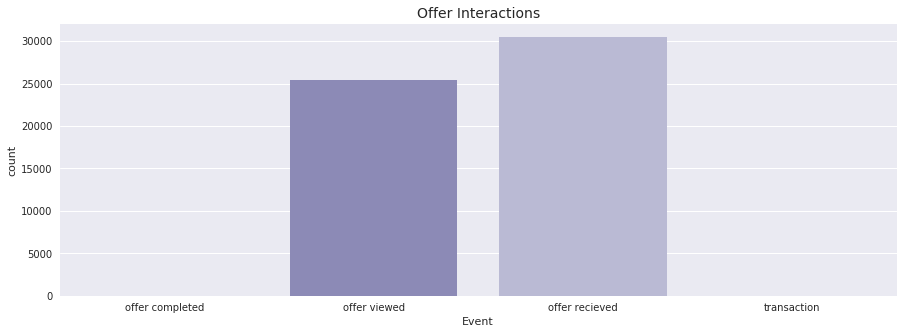

In [65]:
bogo_completed_count = df_bogo['offer completed'].sum() #get sum of values in 'offer_completed'
bogo_viewed_count = df_bogo['offer viewed'].sum() #get sum of values in 'offer_viewed'
bogo_recieved_count = df_bogo['offer received'].sum()#get sum of values in 'offer_received'
bogo_transact_count = df_bogo['transaction'].sum() #get sum of values in 'transaction'

x_vals = ['offer completed','offer viewed','offer recieved','transaction'] #convert it to pandas series
y_vals = [bogo_completed_count, bogo_viewed_count, bogo_recieved_count, bogo_transact_count]

plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Offer Interactions', fontsize = 14)
plt.xlabel('Event')
plt.ylabel('count');

In [66]:
print(bogo_viewed_count/bogo_recieved_count) # get ratio of viewed_count to received_count

0.834420800682


In [67]:
bogo_email_count = df_bogo.email.sum() #get sum of values in 'email'
bogo_mobile_count = df_bogo.mobile.sum() #get sum of values in 'mobile'
bogo_social_count = df_bogo.social.sum() #get sum of values in 'social'
bogo_web_count = df_bogo.web.sum() #get sum of values in 'web'


In [68]:
x_vals = ['email','mobile','social','web'] #convert it to pandas series
y_vals = [bogo_email_count, bogo_mobile_count, bogo_social_count,bogo_web_count]

In [69]:
y_vals

[55948.0, 55948.0, 44100.0, 41574.0]

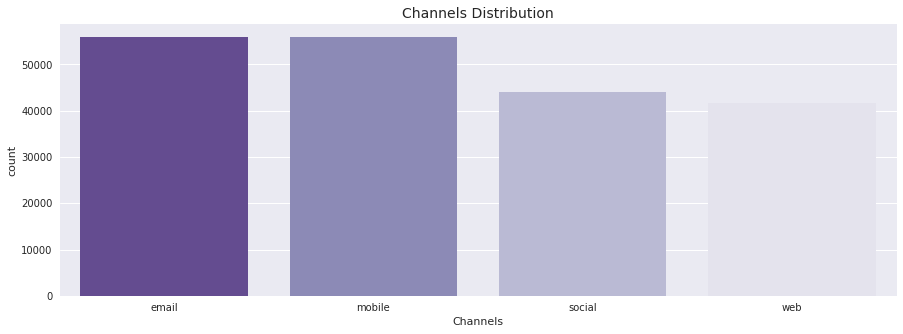

In [70]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Channels Distribution', fontsize = 14)
plt.xlabel('Channels')
plt.ylabel('count');

In [71]:
df_bogo.difficulty.mean() # get the mean value of 'difficulty'

7.6153749910631303

In [72]:
df_bogo.reward.mean() # get the mean value of 'reward'

7.6153749910631303

In [73]:
df_bogo.duration.mean() # get the mean value of 'duration'

5.9373704153857156

In [74]:
df_bogo.income.mean() # get the mean value of 'income'

65426.05401844532

#### Summary for bogo offer:

1) Age group 115-120 has the highest level of interaction with this offer.

2) Users belonging to the income group 50000-60000 has the highest level of interaction with this offer.

3) Among the users who have interacted with this offer, 35.96% are female and 49.67% are male.

4) There is no record of any users completing or transacting under this offer, but more than 83% of users who have received it, has viewed it.

5) The offer is communicated to the users highly through email and mobile, followed by social media then web.

6) The offer has an average difficulty of 7.615 and average reward of 7.615 and average duration it is open is 5.937 days.

### Exploring demographic groups of the informational discount

In [76]:
df_info

,customer_id,time,offer_id,amount,interaction,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward,email,mobile,social,web,age_group,income_group,year
5,0,168,2,0.0,1,0,1,0,0,75,...,3.0,informational,0.0,1.0,1.0,1.0,0.0,75-80,100000.0-110000.0,2017
6,0,216,2,0.0,2,0,0,1,0,75,...,3.0,informational,0.0,1.0,1.0,1.0,0.0,75-80,100000.0-110000.0,2017
22,1,336,6,0.0,1,0,1,0,0,118,...,4.0,informational,0.0,1.0,1.0,0.0,1.0,115-120,nan-nan,2017
23,1,336,6,0.0,2,0,0,1,0,118,...,4.0,informational,0.0,1.0,1.0,0.0,1.0,115-120,nan-nan,2017
24,1,408,2,0.0,1,0,1,0,0,118,...,3.0,informational,0.0,1.0,1.0,1.0,0.0,115-120,nan-nan,2017
33,2,336,6,0.0,1,0,1,0,0,68,...,4.0,informational,0.0,1.0,1.0,0.0,1.0,65-70,70000.0-80000.0,2018
45,3,336,6,0.0,1,0,1,0,0,118,...,4.0,informational,0.0,1.0,1.0,0.0,1.0,115-120,nan-nan,2017
46,3,366,6,0.0,2,0,0,1,0,118,...,4.0,informational,0.0,1.0,1.0,0.0,1.0,115-120,nan-nan,2017
98,7,0,6,0.0,1,0,1,0,0,58,...,4.0,informational,0.0,1.0,1.0,0.0,1.0,55-60,50000.0-60000.0,2017
114,8,336,2,0.0,1,0,1,0,0,61,...,3.0,informational,0.0,1.0,1.0,1.0,0.0,60-65,50000.0-60000.0,2017


In [77]:
print('Female Percentage: ',df_info[df_info['gender']=='F'].shape[0]/df_info.shape[0]) # get the percentage of female in the gender column
print('Male Percentage: ',df_info[df_info['gender']=='M'].shape[0]/df_info.shape[0]) # get the percentage of male in the gender column

Female Percentage:  0.3624645131589043
Male Percentage:  0.49320954500115094


Text(0.5,0,'Age Group')

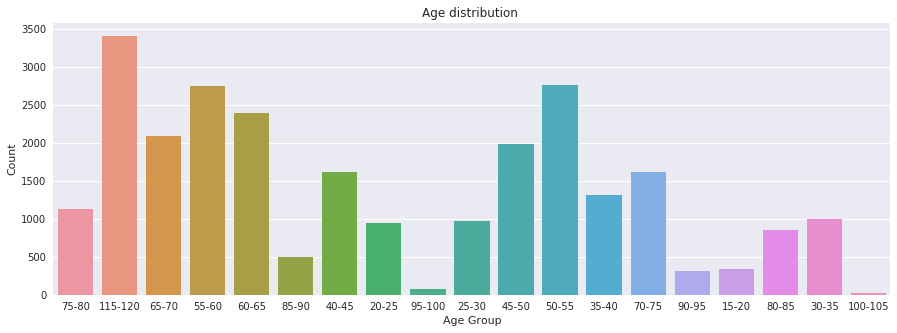

In [78]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", data=df_info)
sns.set(style="darkgrid")
plt.title('Age distribution ')
plt.ylabel('Count')
plt.xlabel('Age Group')


Text(0.5,0,'Income Group')

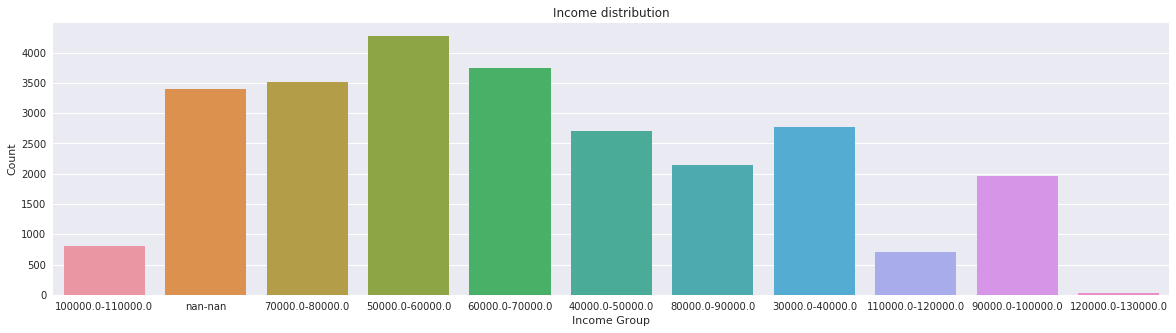

In [79]:
plt.figure(figsize=(20, 5))
sns.countplot(x= "income_group", data=df_info)
sns.set(style="darkgrid")
plt.title('Income distribution')
plt.ylabel('Count')
plt.xlabel('Income Group')


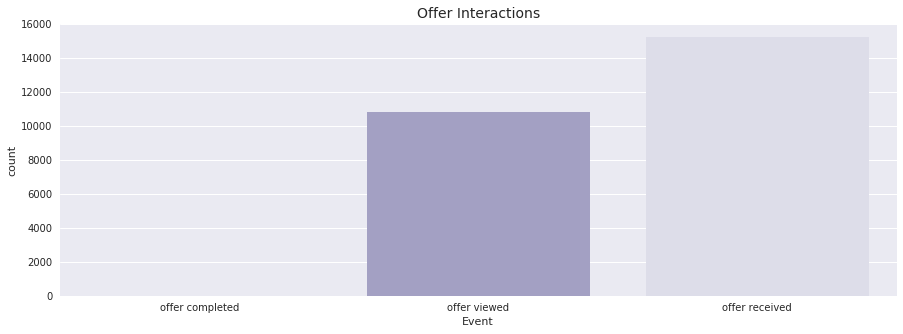

In [80]:
info_completed_count = df_info['offer completed'].sum()#get sum of values in 'offer_completed'
info_viewed_count = df_info['offer viewed'].sum()#get sum of values in 'offer_viewed'
info_recieved_count = df_info['offer received'].sum()#get sum of values in 'offer_reieived'

x_vals = ['offer completed','offer viewed','offer received'] #convert it to pandas series
y_vals = [info_completed_count, info_viewed_count, info_recieved_count]

plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Offer Interactions', fontsize = 14)
plt.xlabel('Event')
plt.ylabel('count');

In [81]:
print(info_viewed_count/info_recieved_count) # get ratio of viewed_count to received_count

0.710928782409


In [82]:
info_email_count = df_info.email.sum() #get sum of values in 'email'
info_mobile_count = df_info.mobile.sum()#get sum of values in 'mobile'
info_social_count = df_info.social.sum()#get sum of values in 'social'
info_web_count = df_info.web.sum()#get sum of values in 'web'


In [83]:
x_vals = ['email','mobile','social','web']
y_vals = [info_email_count, info_mobile_count, info_social_count,info_web_count]

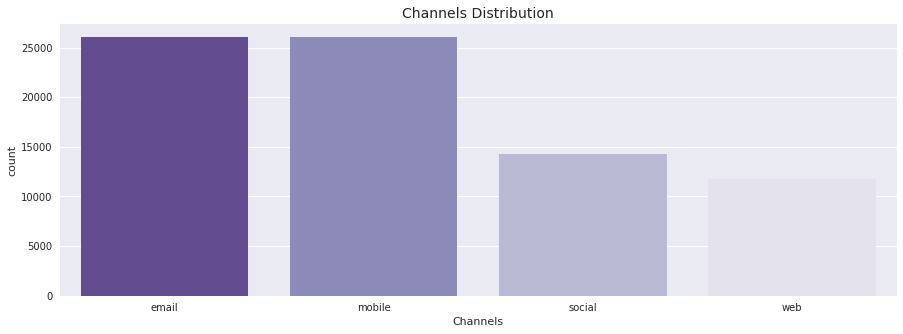

In [84]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Channels Distribution', fontsize = 14)
plt.xlabel('Channels')
plt.ylabel('count');

In [85]:
df_info.difficulty.mean() # get the mean value of 'difficulty'

0.0

In [86]:
df_info.reward.mean() # get the mean value of 'reward'

0.0

In [87]:
df_info.duration.mean() # get the mean value of 'duration'

3.4512007979743728

In [88]:
df_info.income.mean() # get the mean value of 'income'

65450.397175639897

#### Summary for informational offer:

1) Age group 115-120 has the highest level of interaction with this offer.

2) Users belonging to the income group 50000-60000 has the highest level of interaction with this offer.

3) Among the users who have interacted with this offer, 36.25% are female and 49.32% are male.

4) There is no record of any users completing or transacting under this offer, but 72.9% of users who have received it, has viewed it.

5) The offer is communicated to the users highly through email and mobile, followed by social media then web.

6) The offer has an average difficulty of 0 and average reward of 0 and average duration it is open is 3.451 days

### Exploring demographic groups of the discount offer

In [89]:
df_disc

,customer_id,time,offer_id,amount,interaction,offer completed,offer received,offer viewed,transaction,age,...,duration,offer_type,reward,email,mobile,social,web,age_group,income_group,year
18,1,0,5,0.0,1,0,1,0,0,118,...,10.0,discount,5.0,1.0,0.0,0.0,1.0,115-120,nan-nan,2017
19,1,6,5,0.0,2,0,0,1,0,118,...,10.0,discount,5.0,1.0,0.0,0.0,1.0,115-120,nan-nan,2017
25,1,504,5,0.0,1,0,1,0,0,118,...,10.0,discount,5.0,1.0,0.0,0.0,1.0,115-120,nan-nan,2017
26,1,576,5,0.0,1,0,1,0,0,118,...,10.0,discount,5.0,1.0,0.0,0.0,1.0,115-120,nan-nan,2017
28,1,624,5,0.0,2,0,0,1,0,118,...,10.0,discount,5.0,1.0,0.0,0.0,1.0,115-120,nan-nan,2017
29,2,0,7,0.0,1,0,1,0,0,68,...,7.0,discount,2.0,1.0,1.0,0.0,1.0,65-70,70000.0-80000.0,2018
30,2,18,7,0.0,2,0,0,1,0,68,...,7.0,discount,2.0,1.0,1.0,0.0,1.0,65-70,70000.0-80000.0,2018
36,2,504,8,0.0,1,0,1,0,0,68,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,65-70,70000.0-80000.0,2018
37,2,522,8,0.0,2,0,0,1,0,68,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,65-70,70000.0-80000.0,2018
41,3,0,8,0.0,1,0,1,0,0,118,...,10.0,discount,2.0,1.0,1.0,1.0,1.0,115-120,nan-nan,2017


In [91]:
print('Female Percentage: ',df_disc[df_disc['gender']=='F'].shape[0]/df_disc.shape[0]) # get the percentage of female in the gender column
print('Male Percentage: ',df_disc[df_disc['gender']=='M'].shape[0]/df_disc.shape[0]) # get the percentage of male in the gender column

Female Percentage:  0.3592367469416019
Male Percentage:  0.49597984150188507


Text(0.5,0,'Age Group')

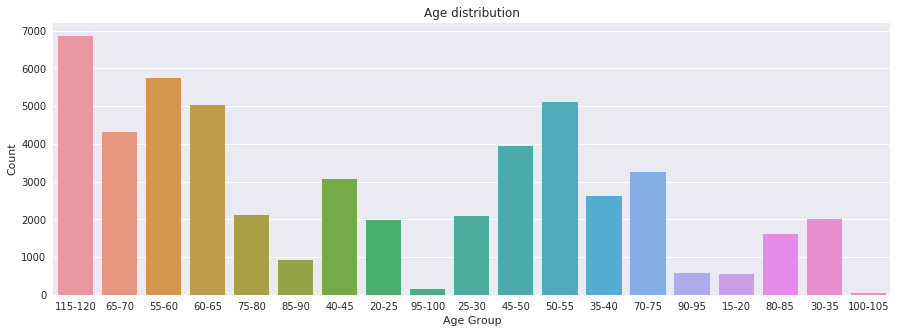

In [92]:
plt.figure(figsize=(15, 5))
sns.countplot(x= "age_group", data=df_disc)
sns.set(style="darkgrid")
plt.title('Age distribution')
plt.ylabel('Count')
plt.xlabel('Age Group')


Text(0.5,0,'Income Group')

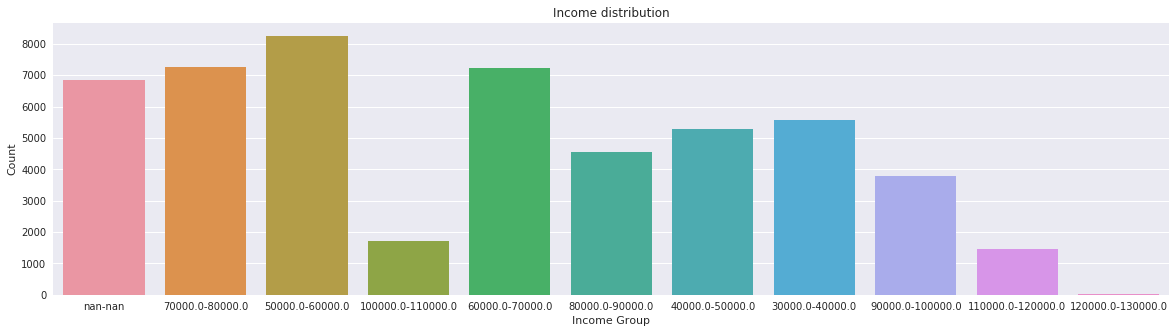

In [93]:
plt.figure(figsize=(20, 5))
sns.countplot(x= "income_group", data=df_disc)
sns.set(style="darkgrid")
plt.title('Income distribution')
plt.ylabel('Count')
plt.xlabel('Income Group')

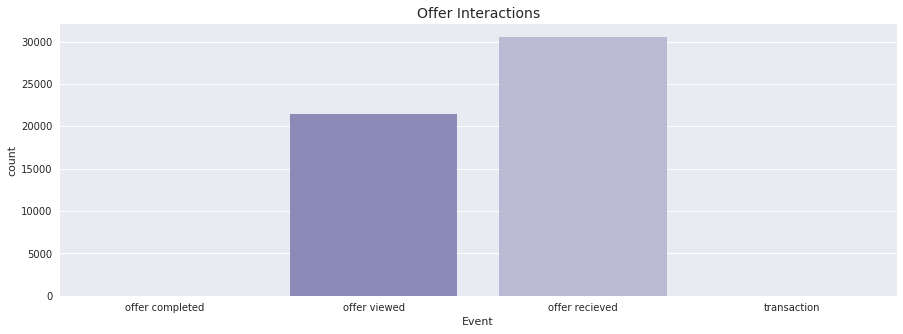

In [94]:
disc_completed_count = df_disc['offer completed'].sum()#get sum of values in 'offer_completed'
disc_viewed_count = df_disc['offer viewed'].sum()#get sum of values in 'offer_viewed'
disc_recieved_count = df_disc['offer received'].sum()#get sum of values in 'offer_reieived'
disc_transact_count = df_disc['transaction'].sum()#get sum of values in 'transaction'

x_vals = ['offer completed','offer viewed','offer recieved','transaction'] #convert it to pandas series
y_vals = [disc_completed_count, disc_viewed_count, disc_recieved_count, disc_transact_count]

plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Offer Interactions', fontsize = 14)
plt.xlabel('Event')
plt.ylabel('count');

In [95]:
print(info_viewed_count/info_recieved_count)# get ratio of viewed_count to received_count

0.710928782409


In [96]:
disc_email_count = df_disc.email.sum()#get sum of values in 'email'
disc_mobile_count = df_disc.mobile.sum()#get sum of values in 'mobile'
disc_social_count = df_disc.social.sum()#get sum of values in 'social'
disc_web_count = df_disc.web.sum()#get sum of values in 'web'

In [97]:
x_vals = ['email','mobile','social','web']
y_vals = [disc_email_count, disc_mobile_count, disc_social_count,disc_web_count]

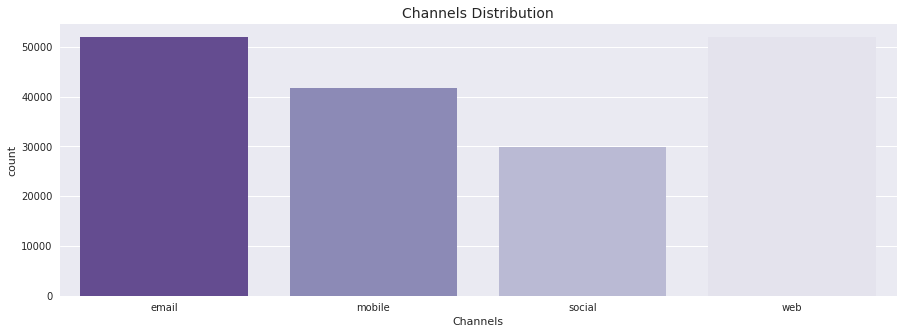

In [98]:
plt.figure(figsize=(15,5))
sns.barplot(x=x_vals, y=y_vals, palette='Purples_r')
plt.title('Channels Distribution', fontsize = 14)
plt.xlabel('Channels')
plt.ylabel('count');

In [99]:
df_disc.difficulty.mean()# get the mean value of 'difficulty'

11.122585981380318

In [100]:
df_disc.reward.mean()# get the mean value of 'reward'

2.884357928752789

In [101]:
df_disc.duration.mean() # get the mean value of 'duration'

8.4573555435869814

In [102]:
df_disc.income.mean() # get the mean value of 'income'

65792.753462603883

#### Summary for Discount offer:

1) Age group 115-120 has the highest level of interaction with this offer.

2) Users belonging to the income group 50000-60000 has the highest level of interaction with this offer.

3) Among the users who have interacted with this offer, 35.92% are female and 49.59% are male.

4) There is no record of any users completing or transacting under this offer, but 83% of users who have received it, has viewed it.

5) The offer is communicated to the users highly through email and web, followed by mobile and then social media.

6) The offer has an average difficulty of 11.12 and average reward of 2.88 and average duration it is open is 8.457 days

### Imputing Missing Values

In [104]:
fill_mean = lambda col:col.fillna(col.mean()) # function to fll null values with the mean of the column
df[['income']] = df[['income']].apply(fill_mean) # apply fill_mean to the 'income' column


### Model Building

In [105]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score

In [106]:
X = df[['customer_id','time','amount','offer_id','time', 'age','income']] # store the features in X
y = df['interaction'] # store the target variable in y
X_train, X_test, y_train, y_test = train_test_split(X, y) # split the data into training and testing set

#### AdaBoostClassifier

In [107]:
ada_model = AdaBoostClassifier() # initialise AdaBoostClassifier

In [108]:
ada_model.fit(X_train,y_train) # fit the training data

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [109]:
y_pred = ada_model.predict(X_test) # predict for the test set
y_pred

array([3, 3, 1, ..., 3, 1, 1])

In [110]:
print('Accuracy: ',(y_pred==y_test).mean()) # get accuracy of the model

Accuracy:  0.811363102539


In [111]:
confusion_matrix(y_test,y_pred) # get confusion matrix for the classifier

array([[ 8369,     0,     0,     0],
       [    0, 19196,     0,     0],
       [    0, 14456,     0,     0],
       [    0,     0,     0, 34613]])

#### Random Forest Classifier

In [112]:
rfc_model = RandomForestClassifier(max_depth = 2) # initialise RandomForestClassifier

In [113]:
rfc_model.fit(X_train,y_train)  # fit the training data

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [114]:
y_pred = rfc_model.predict(X_test) # predict for the test set
y_pred

array([3, 3, 1, ..., 3, 1, 1])

In [115]:
print('Accuracy: ',(y_pred==y_test).mean()) # get accuracy of the model

Accuracy:  0.720933267218


In [116]:
print('Confusion Matrix: ',confusion_matrix(y_test,y_pred)) # get confusion matrix for the classifier

array([[ 3087,    47,     0,  5235],
       [  439, 17600,     0,  1157],
       [  297, 13466,     0,   693],
       [    0,    52,     0, 34561]])

#### KMeans Classifier

In [117]:
knn_model = KNeighborsClassifier(5) # Initialise KNN Classifier

In [118]:
knn_model.fit(X_train,y_train) # fit the training data

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [119]:
y_pred = knn_model.predict(X_test) # predict for the test set
y_pred

array([3, 3, 1, ..., 3, 0, 1])

In [120]:
print('Accuracy: ',(y_pred==y_test).mean()) # get accuracy of the model

Accuracy:  0.373332985359


In [121]:
confusion_matrix(y_test,y_pred) # get confusion matrix for the classifier

array([[  480,  2516,  1178,  4195],
       [ 1861,  7457,  3809,  6069],
       [ 1525,  6816,   785,  5330],
       [ 2721,  8349,  3655, 19888]])

### Model Summary

1) The AdaBoostClassifier has the highest accuracy of 0.812

2) The Random Forest Classifier has second highest accuracy 0f 0.803

3) The KNN Classifier has the least accuracy of 0.37